# Modeling Tabular Data

In [1]:
from prep_pipeline import *
from imports import *
from scipy.stats.stats import pearsonr 
from CogDataset3d import *
import lazypredict
from lazypredict.Supervised import LazyRegressor

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

/home/cpabalan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df = pd.read_csv('cleaned_df_5_31.csv')
X_tr, X_v = get_file_splits()
X_train, X_val, y_adas_train, y_adas_val, y_mmse_train, y_mmse_val= split_train_val(X_tr, X_v, df)

In [4]:
X_train.columns

Index(['AGE', 'PTEDUCAT', 'APOE4', 'ABETA_bl', 'TAU_bl', 'PTAU_bl', 'M',
       'DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI', 'DX_bl_LMCI', 'DX_bl_SMC',
       'PTGENDER_Female', 'PTGENDER_Male', 'PTGENDER_nan', 'PTMARRY_Divorced',
       'PTMARRY_Married', 'PTMARRY_Never married'],
      dtype='object')

# Factors
1. Age
2. Education
3. Apolipoprotein E4
4. ABETA
5. TAU
6. M
7. DX
8. Gender
9. Married

In [6]:
X_train.shape, X_val.shape

((1158, 18), (247, 18))

## Lazy Predict for ADAS11 

In [8]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
ADAS_models, ADAS_predictions = reg.fit(X_train, X_val, y_adas_train, y_adas_val)
ADAS_predictions[:10]

 26%|██▌       | 11/42 [00:01<00:03,  9.06it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|██████████| 42/42 [00:05<00:00,  7.91it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.46,0.50,7.08,0.22
HistGradientBoostingRegressor,0.44,0.48,7.20,0.73
MLPRegressor,0.44,0.48,7.20,1.16
LGBMRegressor,0.41,0.45,7.37,0.16
BayesianRidge,0.40,0.44,7.46,0.02
ExtraTreesRegressor,0.40,0.44,7.47,0.49
ElasticNetCV,0.40,0.44,7.47,0.12
LassoLarsCV,0.39,0.44,7.47,0.05
LassoCV,0.39,0.44,7.47,0.12


In [74]:
from sklearn.ensemble import *
pipe = Pipeline([('regressor', HistGradientBoostingRegressor(loss = 'poisson', l2_regularization=.25, max_depth = 6, random_state=42))])
pipe.fit(X_train, y_adas_train)
hgradboost_pred = pipe.predict(X_val)
hgradboost_pred_train = pipe.predict(X_train)

print(f"{'hgradboost Train Loss'}: {round(mean_squared_error(y_adas_train, hgradboost_pred_train),3)}")
print(f"{'hgradboost Train R2  '}: {round(r2_score(y_adas_train, hgradboost_pred_train),3)}\n")
print(f"{'hgradboost Valid Loss'}: {round(mean_squared_error(y_adas_val, hgradboost_pred),3)}")
print(f"{'hgradboost Valid R2  '}: {round(r2_score(y_adas_val, hgradboost_pred),3)}\n")

hgradboost Train Loss: 20.682
hgradboost Train R2  : 0.801

hgradboost Valid Loss: 49.192
hgradboost Valid R2  : 0.506



In [75]:
# from joblib import dump, load
# dump(pipe, 'hgb_model.joblib') 

['hgb_model.joblib']

In [73]:
print(f'Validation Corr: {round(pearsonr(hgradboost_pred, y_adas_val)[0],3)}')
print(f'Train Corr: {round(pearsonr(hgradboost_pred_train, y_adas_train)[0],3)}')

Validation Corr: 0.711
Train Corr: 0.902


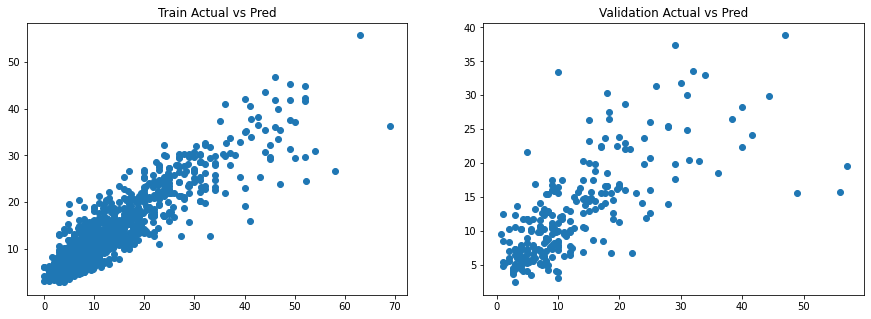

In [72]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
ax[1].scatter(y_adas_val, hgradboost_pred)
ax[1].set_title('Validation Actual vs Pred')
ax[0].scatter(y_adas_train, hgradboost_pred_train)
ax[0].set_title('Train Actual vs Pred')
plt.show()